**Learning Python -- The Programming Language for Artificial Intelligence and Data Science**

**Lecture: Deep Neural Networks**

By Allen Y. Yang, PhD

(c) Copyright Intelligent Racing Inc., 2021-2024. All rights reserved. Materials may NOT be distributed or used for any commercial purposes.

# Keywords

* **Multi-Layer Perceptron (MLP)**: Neural network with one or more hidden layers between input and output
* **Hidden Layer**: Intermediate layers in a neural network that learn abstract representations
* **Softmax Function**: Converts a vector of real numbers into probabilities that sum to 1
* **ReLU (Rectified Linear Unit)**: Activation function that outputs max(0, x)
* **Backpropagation**: Algorithm for training neural networks by propagating errors backward
* **Convolutional Neural Network (CNN)**: Specialized neural network for processing grid-like data (images)
* **Convolution**: Mathematical operation that applies filters to detect features
* **Max-Pooling**: Downsampling operation that takes maximum value in a region
* **Dropout**: Regularization technique that randomly disables neurons during training
* **Flatten**: Operation that converts multi-dimensional data into a 1D vector

# Review of Last Lecture

In the previous lecture, we learned about:
- **Perceptron**: Single neuron that can solve linearly separable problems
- **Linear Separability**: Classes that can be separated by a straight line (or hyperplane)
- **Activation Functions**: Step function and sigmoid
- **Gradient Descent**: Algorithm for finding optimal weights

## Key Limitation: The XOR Problem

A single perceptron cannot solve problems that are **not linearly separable**, such as the XOR (exclusive OR) function.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

2025-07-13 14:13:44.883052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0
NumPy version: 1.23.5


# The XOR Problem: Why We Need Hidden Layers

The XOR problem demonstrates a fundamental limitation of single-layer perceptrons. Let's visualize it:

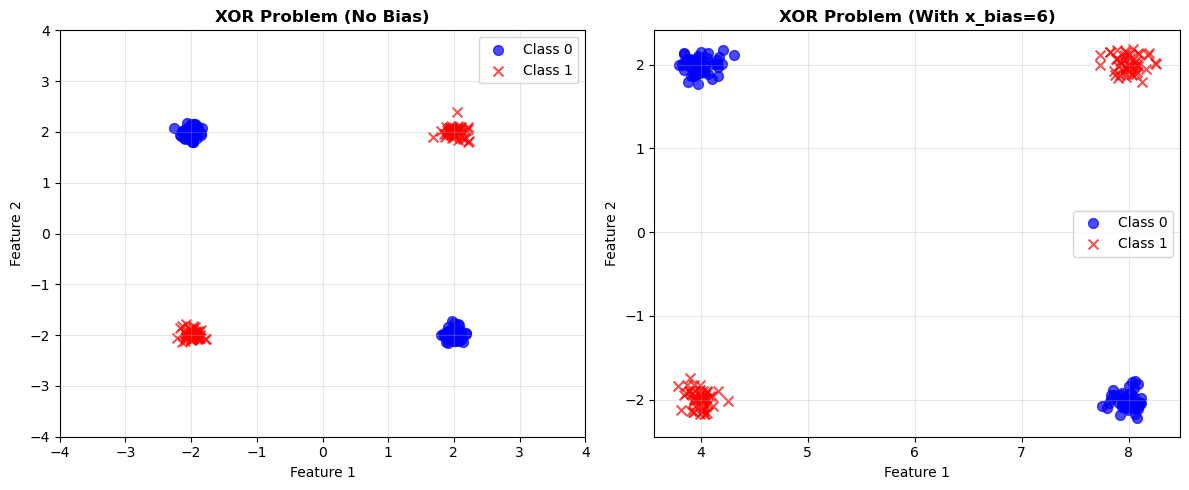

Notice: No single straight line can separate the two classes!


In [2]:
# Generate XOR dataset
def generate_xor_data(n_samples=200, noise=0.1, x_bias=0):
    """Generate XOR dataset with optional bias shift"""
    samples_per_cluster = n_samples // 4
    
    # Class 0: top-left and bottom-right
    cluster1 = np.random.randn(samples_per_cluster, 2) * noise + [-2 + x_bias, 2]
    cluster2 = np.random.randn(samples_per_cluster, 2) * noise + [2 + x_bias, -2]
    
    # Class 1: top-right and bottom-left
    cluster3 = np.random.randn(samples_per_cluster, 2) * noise + [2 + x_bias, 2]
    cluster4 = np.random.randn(samples_per_cluster, 2) * noise + [-2 + x_bias, -2]
    
    # Combine data
    X_class0 = np.vstack([cluster1, cluster2])
    X_class1 = np.vstack([cluster3, cluster4])
    
    X = np.vstack([X_class0, X_class1])
    y = np.hstack([np.zeros(2 * samples_per_cluster), np.ones(2 * samples_per_cluster)])
    
    return X, y, X_class0, X_class1

# Generate data with and without bias
X_xor, y_xor, X_class0, X_class1 = generate_xor_data(x_bias=0)
X_xor_bias, y_xor_bias, X_class0_bias, X_class1_bias = generate_xor_data(x_bias=6)

# Visualize XOR problem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Without bias
ax1.scatter(X_class0[:, 0], X_class0[:, 1], c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
ax1.scatter(X_class1[:, 0], X_class1[:, 1], c='red', marker='x', s=50, alpha=0.7, label='Class 1')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('XOR Problem (No Bias)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

# With bias
ax2.scatter(X_class0_bias[:, 0], X_class0_bias[:, 1], c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
ax2.scatter(X_class1_bias[:, 0], X_class1_bias[:, 1], c='red', marker='x', s=50, alpha=0.7, label='Class 1')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title('XOR Problem (With x_bias=6)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice: No single straight line can separate the two classes!")

## Attempting to Solve XOR with a Single Perceptron

Let's verify that a single perceptron fails on the XOR problem:

Single Perceptron Accuracy on XOR: 50.00%
Expected: ~50% (no better than random guessing)


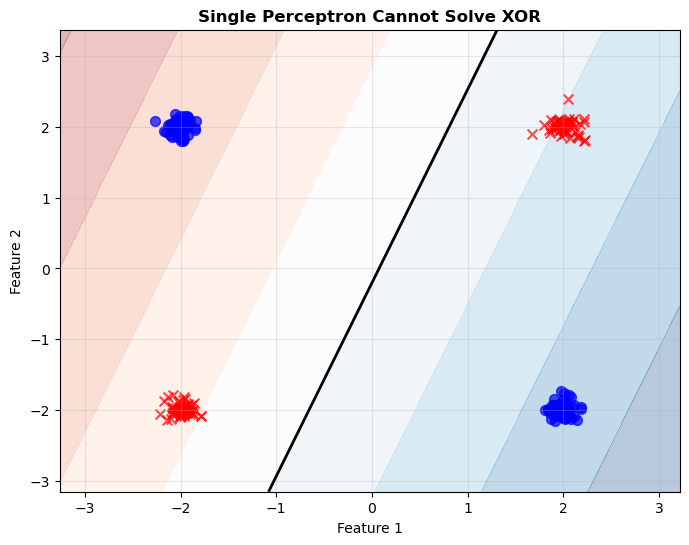

In [3]:
# Try single perceptron on XOR
single_perceptron = keras.Sequential([
    layers.Dense(1, input_shape=(2,), activation='sigmoid')
])

single_perceptron.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train on XOR data
history = single_perceptron.fit(
    X_xor, y_xor,
    epochs=100,
    batch_size=10,
    verbose=0
)

# Evaluate
loss, accuracy = single_perceptron.evaluate(X_xor, y_xor, verbose=0)
print(f"Single Perceptron Accuracy on XOR: {accuracy:.2%}")
print("Expected: ~50% (no better than random guessing)")

# Visualize decision boundary
h = 0.02
x_min, x_max = X_xor[:, 0].min() - 1, X_xor[:, 0].max() + 1
y_min, y_max = X_xor[:, 1].min() - 1, X_xor[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = single_perceptron.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
plt.scatter(X_class0[:, 0], X_class0[:, 1], c='blue', marker='o', s=50, alpha=0.7)
plt.scatter(X_class1[:, 0], X_class1[:, 1], c='red', marker='x', s=50, alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Single Perceptron Cannot Solve XOR', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# Multi-Layer Perceptron (MLP)

To solve non-linearly separable problems, we need **hidden layers**. A Multi-Layer Perceptron has:
- **Input layer**: Receives the features
- **Hidden layer(s)**: Learn abstract representations
- **Output layer**: Produces the final predictions

## Key Innovation: Hidden Layers Create New Feature Spaces

Hidden layers transform the input space into a new representation where the classes become linearly separable!

In [4]:
# Build MLP to solve XOR
mlp_xor = keras.Sequential([
    layers.Dense(4, input_shape=(2,), activation='sigmoid'),  # Hidden layer with 4 neurons
    layers.Dense(1, activation='sigmoid')                      # Output layer
])

mlp_xor.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
mlp_xor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


MLP Accuracy on XOR: 75.00%


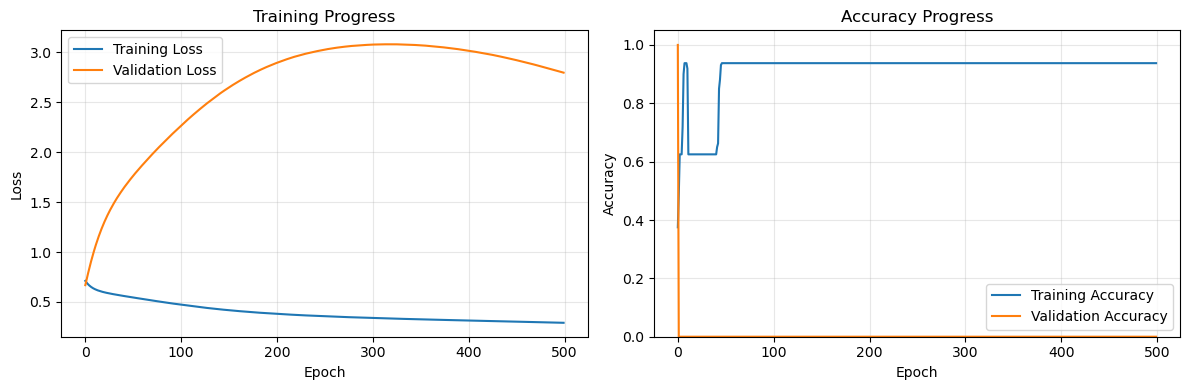

In [5]:
# Train MLP on XOR
history_mlp = mlp_xor.fit(
    X_xor, y_xor,
    epochs=500,
    batch_size=10,
    verbose=0,
    validation_split=0.2
)

# Evaluate
loss, accuracy = mlp_xor.evaluate(X_xor, y_xor, verbose=0)
print(f"MLP Accuracy on XOR: {accuracy:.2%}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history_mlp.history['loss'], label='Training Loss')
ax1.plot(history_mlp.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_mlp.history['accuracy'], label='Training Accuracy')
ax2.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Progress')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

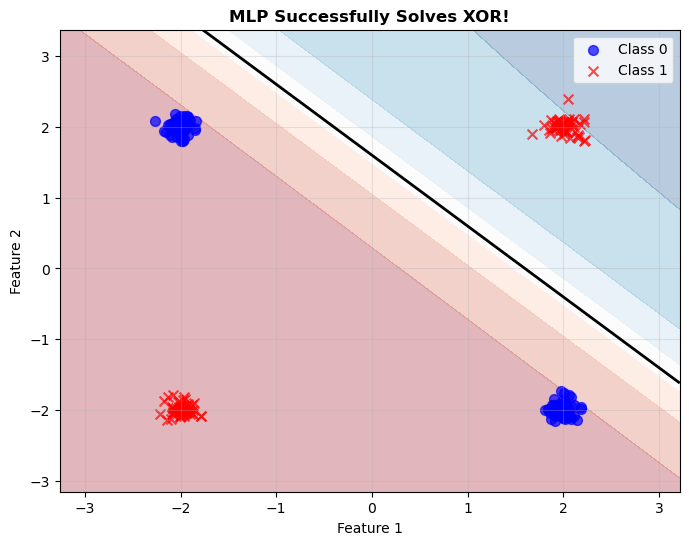

Notice: The MLP creates a non-linear decision boundary!


In [6]:
# Visualize MLP decision boundary
Z_mlp = mlp_xor.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)
Z_mlp = Z_mlp.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_mlp, alpha=0.3, cmap=plt.cm.RdBu)
plt.contour(xx, yy, Z_mlp, levels=[0.5], colors='black', linewidths=2)
plt.scatter(X_class0[:, 0], X_class0[:, 1], c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
plt.scatter(X_class1[:, 0], X_class1[:, 1], c='red', marker='x', s=50, alpha=0.7, label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('MLP Successfully Solves XOR!', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Notice: The MLP creates a non-linear decision boundary!")

# Multi-Class Classification with Softmax

For problems with more than 2 classes, we use:
- **One-hot encoding**: Represent each class as a binary vector
- **Softmax activation**: Convert outputs to probabilities

## Softmax Function

For a vector $z = [z_1, z_2, ..., z_m]$:

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{m} e^{z_j}}$$

Properties:
- All outputs are between 0 and 1
- Outputs sum to 1 (valid probability distribution)
- Emphasizes the largest value

Softmax Example:
Input z: [ 0.5  6.  -2.6]
Softmax output: [4.06939157e-03 9.95747286e-01 1.83322844e-04]
Percentages: [4.06939157e-01 9.95747286e+01 1.83322844e-02]
Sum: 1.000000


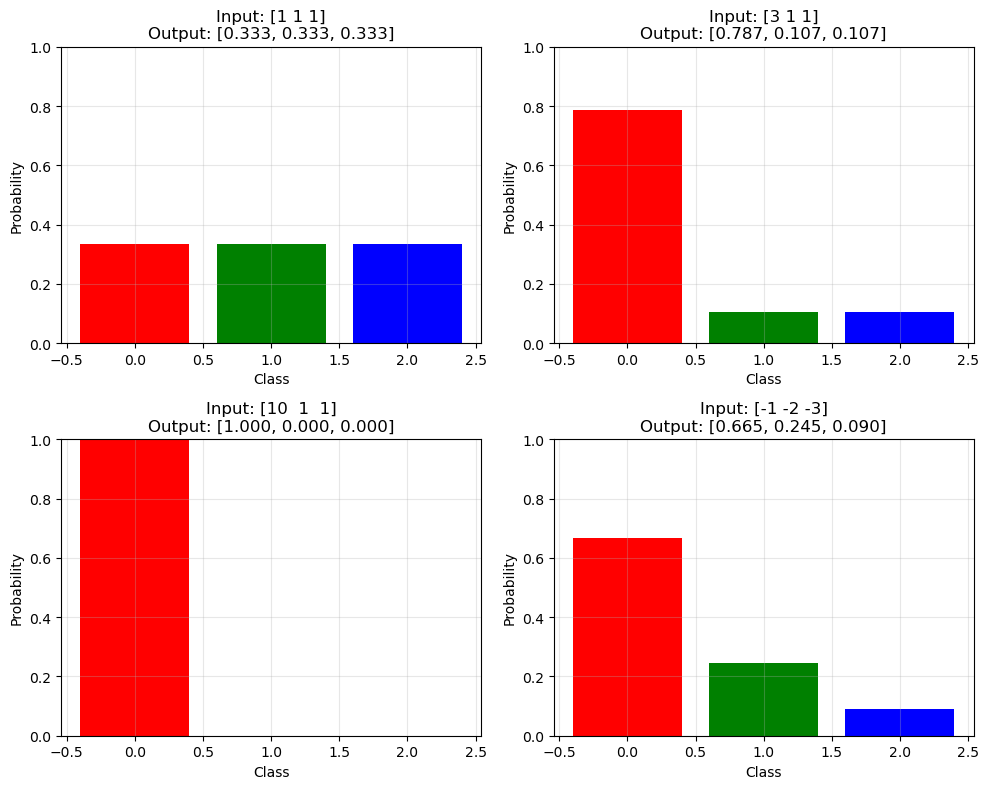

In [7]:
# Demonstrate softmax function
def softmax(z):
    """Compute softmax values for each sets of scores in z."""
    exp_z = np.exp(z - np.max(z))  # Subtract max for numerical stability
    return exp_z / exp_z.sum()

# Example
z_example = np.array([0.5, 6.0, -2.6])
softmax_output = softmax(z_example)

print("Softmax Example:")
print(f"Input z: {z_example}")
print(f"Softmax output: {softmax_output}")
print(f"Percentages: {softmax_output * 100}")
print(f"Sum: {softmax_output.sum():.6f}")

# Visualize softmax for different inputs
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

test_inputs = [
    np.array([1, 1, 1]),        # Equal inputs
    np.array([3, 1, 1]),        # One larger
    np.array([10, 1, 1]),       # One much larger
    np.array([-1, -2, -3])      # Negative inputs
]

for i, z in enumerate(test_inputs):
    probs = softmax(z)
    axes[i].bar(range(len(z)), probs, color=['red', 'green', 'blue'])
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f'Input: {z}\nOutput: [{probs[0]:.3f}, {probs[1]:.3f}, {probs[2]:.3f}]')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Implementing the Complete MLP from mlp.py

Let's implement the full MLP example from the provided code, which handles the XOR problem with proper visualization:

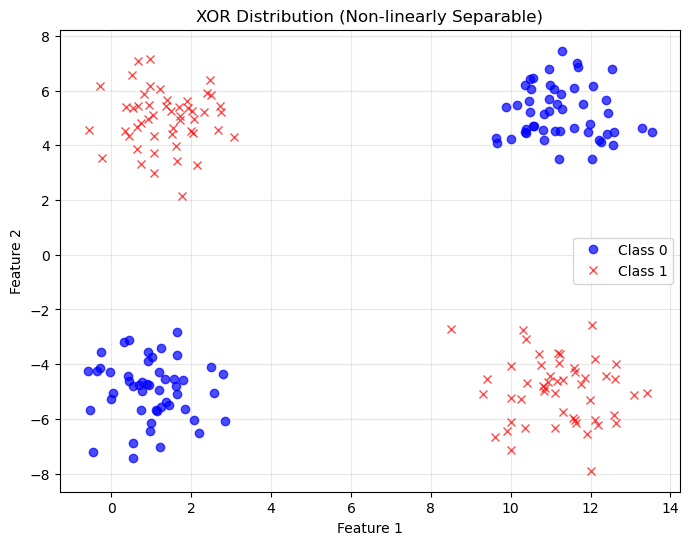

In [8]:
# Implementation based on mlp.py
def toy_2D_samples(x_bias, linearSeparableFlag):
    """Generate 2D samples for classification"""
    if linearSeparableFlag:
        samples1 = np.random.multivariate_normal([5+x_bias, 0], [[1, 0],[0, 1]], 100)
        samples2 = np.random.multivariate_normal([-5+x_bias, 0], [[1, 0],[0, 1]], 100)
        samples = np.concatenate((samples1, samples2), axis=0)
        
        # Plot the data
        plt.figure(figsize=(8, 6))
        plt.plot(samples1[:, 0], samples1[:, 1], 'bo', label='Class 0')
        plt.plot(samples2[:, 0], samples2[:, 1], 'rx', label='Class 1')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Linearly Separable Data')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    else:
        # XOR-like distribution
        samples1 = np.random.multivariate_normal([5+x_bias, 5], [[1, 0],[0, 1]], 50)
        samples2 = np.random.multivariate_normal([-5+x_bias, -5], [[1, 0],[0, 1]], 50)
        samples3 = np.random.multivariate_normal([-5+x_bias, 5], [[1, 0],[0, 1]], 50)
        samples4 = np.random.multivariate_normal([5+x_bias, -5], [[1, 0],[0, 1]], 50)
        
        samples = np.concatenate((samples1, samples2, samples3, samples4), axis=0)
        
        # Plot the data
        plt.figure(figsize=(8, 6))
        plt.plot(samples1[:, 0], samples1[:, 1], 'bo', alpha=0.7)
        plt.plot(samples2[:, 0], samples2[:, 1], 'bo', alpha=0.7, label='Class 0')
        plt.plot(samples3[:, 0], samples3[:, 1], 'rx', alpha=0.7)
        plt.plot(samples4[:, 0], samples4[:, 1], 'rx', alpha=0.7, label='Class 1')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('XOR Distribution (Non-linearly Separable)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Create labels (one-hot encoded)
    label1 = np.array([[1, 0]])
    label2 = np.array([[0, 1]])
    labels1 = np.repeat(label1, 100, axis=0)
    labels2 = np.repeat(label2, 100, axis=0)
    labels = np.concatenate((labels1, labels2), axis=0)
    
    return samples, labels

# Generate non-linearly separable data
linearSeparableFlag = False
x_bias = 6
samples, labels = toy_2D_samples(x_bias, linearSeparableFlag)

In [9]:
# Split training and testing set
def train_test_split_manual(samples, labels, test_size=0.5, random_state=None):
    """Manual train-test split"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(samples)
    indices = np.random.permutation(n_samples)
    
    n_train = int(n_samples * (1 - test_size))
    train_idx = indices[:n_train]
    test_idx = indices[n_train:]
    
    return samples[train_idx], samples[test_idx], labels[train_idx], labels[test_idx]

trainingX, testingX, trainingY, testingY = train_test_split_manual(samples, labels, test_size=0.5)

print(f"Training samples: {len(trainingX)}")
print(f"Testing samples: {len(testingX)}")
print(f"Input shape: {trainingX[0].shape}")
print(f"Output shape: {trainingY[0].shape}")

Training samples: 100
Testing samples: 100
Input shape: (2,)
Output shape: (2,)


In [10]:
# Build and train MLP model
model = keras.Sequential([
    layers.Dense(4, input_shape=(2,), activation='sigmoid', use_bias=True),
    layers.Dense(2, activation='softmax')
])

model.compile(
    loss='mean_squared_error',
    optimizer='sgd',
    metrics=['binary_accuracy']
)

# Display model architecture
model.summary()

# Train the model
history = model.fit(
    trainingX, trainingY,
    epochs=500,
    batch_size=10,
    verbose=0,
    validation_split=0.2
)

print("\nTraining complete!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________

Training complete!


Test accuracy: 70.00%


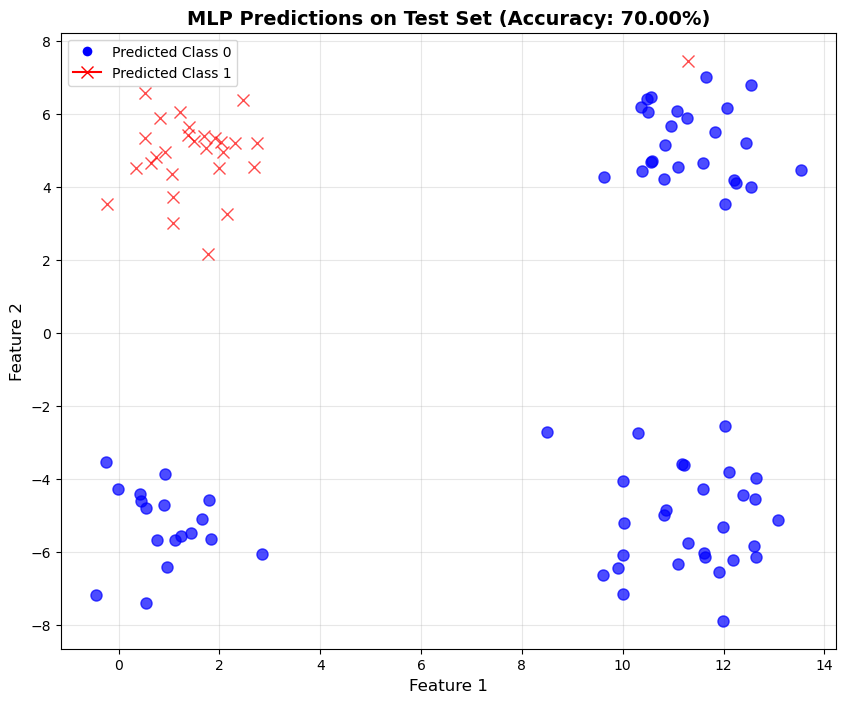

In [11]:
# Evaluate and visualize predictions
score = 0
predictions = []

plt.figure(figsize=(10, 8))

for i in range(len(testingX)):
    predict_x = model.predict(np.array([testingX[i,:]]), verbose=0)
    estimate = np.argmax(predict_x, axis=1)[0]
    
    # Store prediction for analysis
    predictions.append(estimate)
    
    # Check if prediction is correct
    if testingY[i, estimate] == 1:
        score = score + 1
    
    # Plot with prediction
    if estimate == 0:
        plt.plot(testingX[i, 0], testingX[i, 1], 'bo', markersize=8, alpha=0.7)
    else:
        plt.plot(testingX[i, 0], testingX[i, 1], 'rx', markersize=8, alpha=0.7)

accuracy = score / len(testingX)
print(f'Test accuracy: {accuracy:.2%}')

plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title(f'MLP Predictions on Test Set (Accuracy: {accuracy:.2%})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Predicted Class 0',
                          markerfacecolor='b', markersize=8),
                   Line2D([0], [0], marker='x', color='r', label='Predicted Class 1',
                          markersize=8)]
plt.legend(handles=legend_elements)
plt.show()

# ReLU Activation Function

## Rectified Linear Unit (ReLU)

ReLU is the most popular activation function in modern deep learning:

$$\text{ReLU}(z) = \max(0, z) = \begin{cases} 0 & \text{if } z \leq 0 \\ z & \text{if } z > 0 \end{cases}$$

### Advantages over Sigmoid:
1. **No vanishing gradient**: Derivative is constant (0 or 1)
2. **Sparsity**: Outputs exactly 0 for negative inputs
3. **Computational efficiency**: Simple max operation
4. **Faster convergence**: Generally trains faster

### Disadvantages:
1. **Dying ReLU**: Neurons can get stuck outputting 0
2. **Not differentiable at 0**: Though rarely an issue in practice

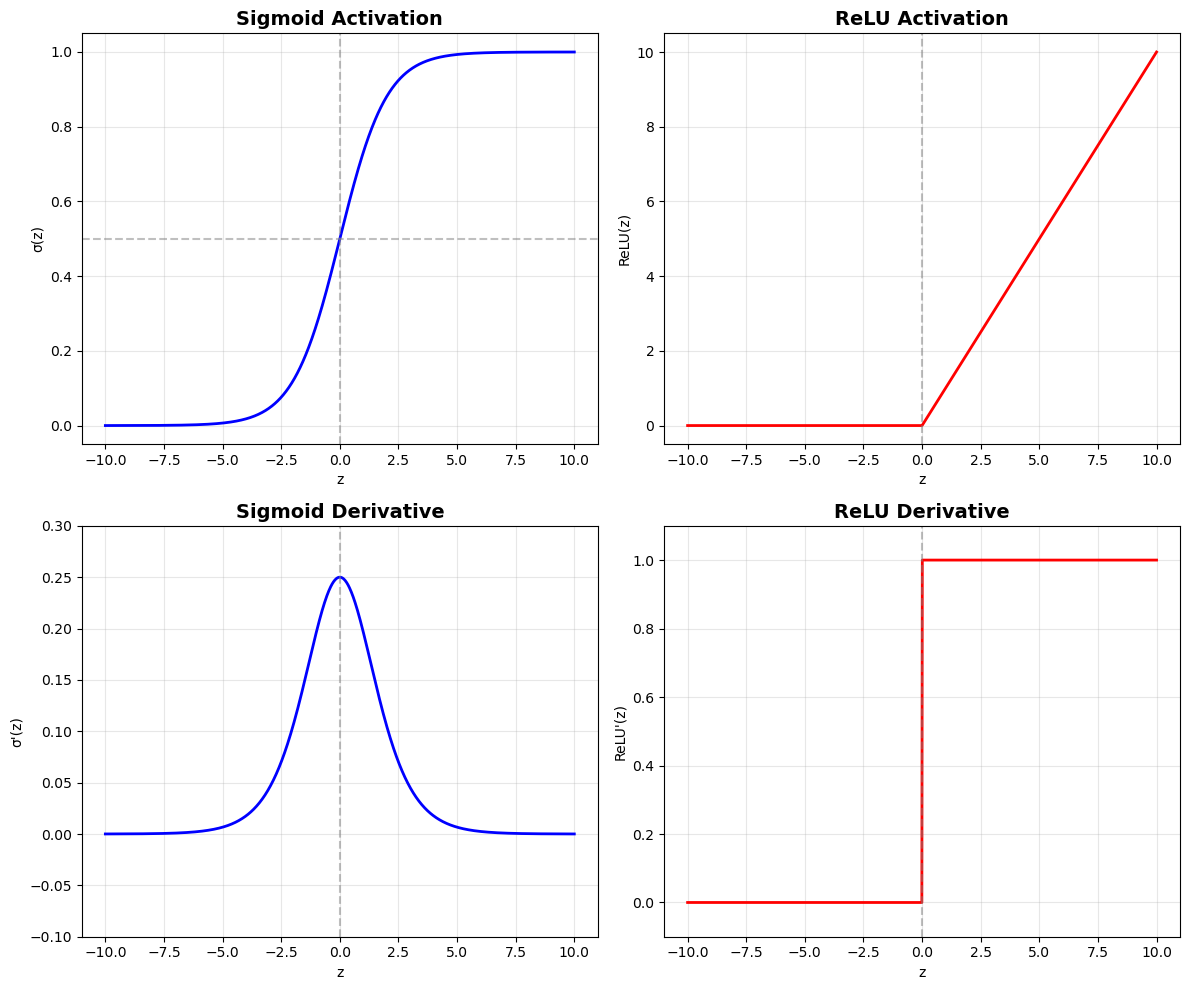

Key observations:
1. Sigmoid saturates for large |z|, causing vanishing gradients
2. ReLU has constant gradient for positive inputs
3. ReLU creates sparsity by outputting exact zeros


In [12]:
# Compare activation functions
z = np.linspace(-10, 10, 1000)

# Compute activations
sigmoid = 1 / (1 + np.exp(-z))
relu = np.maximum(0, z)

# Compute derivatives
sigmoid_derivative = sigmoid * (1 - sigmoid)
relu_derivative = (z > 0).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Sigmoid
axes[0, 0].plot(z, sigmoid, 'b-', linewidth=2)
axes[0, 0].set_title('Sigmoid Activation', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('z')
axes[0, 0].set_ylabel('σ(z)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# ReLU
axes[0, 1].plot(z, relu, 'r-', linewidth=2)
axes[0, 1].set_title('ReLU Activation', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('z')
axes[0, 1].set_ylabel('ReLU(z)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Sigmoid derivative
axes[1, 0].plot(z, sigmoid_derivative, 'b-', linewidth=2)
axes[1, 0].set_title('Sigmoid Derivative', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('z')
axes[1, 0].set_ylabel("σ'(z)")
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_ylim(-0.1, 0.3)

# ReLU derivative
axes[1, 1].plot(z, relu_derivative, 'r-', linewidth=2)
axes[1, 1].set_title('ReLU Derivative', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('z')
axes[1, 1].set_ylabel("ReLU'(z)")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

print("Key observations:")
print("1. Sigmoid saturates for large |z|, causing vanishing gradients")
print("2. ReLU has constant gradient for positive inputs")
print("3. ReLU creates sparsity by outputting exact zeros")

## Comparing Sigmoid vs ReLU on XOR Problem

Training with Sigmoid activation...
Training with ReLU activation...


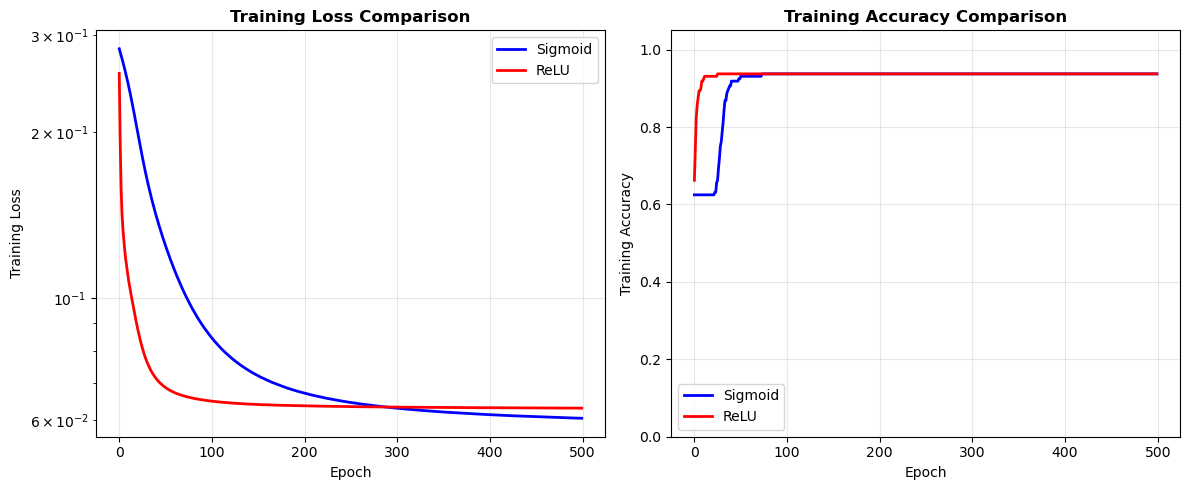


Conclusion: In most cases, ReLU performs better than Sigmoid!


In [13]:
# Compare activation functions on XOR
def create_and_train_mlp(activation, X, y, epochs=500):
    """Create and train MLP with specified activation"""
    model = keras.Sequential([
        layers.Dense(4, input_shape=(2,), activation=activation),
        layers.Dense(2, activation='softmax')
    ])
    
    model.compile(
        loss='mean_squared_error',
        optimizer='sgd',
        metrics=['binary_accuracy']
    )
    
    # Convert y to one-hot if needed
    if len(y.shape) == 1:
        y_onehot = keras.utils.to_categorical(y, 2)
    else:
        y_onehot = y
    
    history = model.fit(
        X, y_onehot,
        epochs=epochs,
        batch_size=10,
        verbose=0,
        validation_split=0.2
    )
    
    return model, history

# Train with different activations
print("Training with Sigmoid activation...")
model_sigmoid, history_sigmoid = create_and_train_mlp('sigmoid', samples, labels)

print("Training with ReLU activation...")
model_relu, history_relu = create_and_train_mlp('relu', samples, labels)

# Compare training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_sigmoid.history['loss'], 'b-', label='Sigmoid', linewidth=2)
plt.plot(history_relu.history['loss'], 'r-', label='ReLU', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(history_sigmoid.history['binary_accuracy'], 'b-', label='Sigmoid', linewidth=2)
plt.plot(history_relu.history['binary_accuracy'], 'r-', label='ReLU', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

print("\nConclusion: In most cases, ReLU performs better than Sigmoid!")

# MNIST Classification with MLP

Now let's apply MLPs to a real-world problem: handwritten digit recognition using the MNIST dataset.

## The MNIST Dataset
- 60,000 training images, 10,000 test images
- 28×28 grayscale images of handwritten digits (0-9)
- Human average accuracy: 99.8%

In [14]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist

# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(np.unique(y_train))}")
print(f"Image dimensions: {x_train.shape[1]} × {x_train.shape[2]}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)

Number of classes: 10
Image dimensions: 28 × 28


First 20 labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


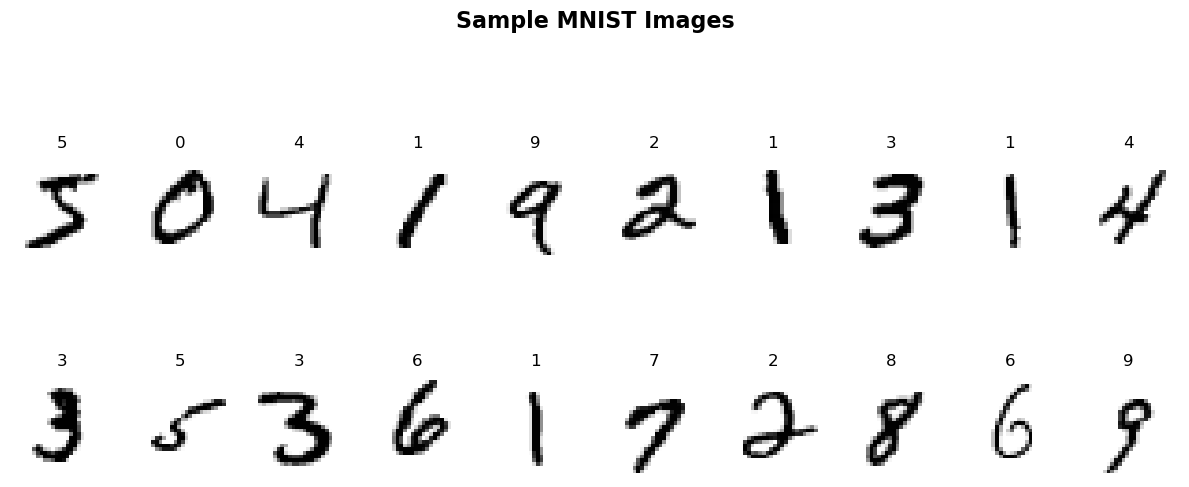

In [15]:
# Visualize sample images
print("First 20 labels:", y_train[0:20])

plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.title(str(y_train[i]))
    plt.axis('off')

plt.suptitle('Sample MNIST Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
# Preprocess the data
# Reshape images to 1D vectors
img_rows, img_cols = 28, 28
x_train_flat = x_train.reshape(x_train.shape[0], img_rows * img_cols)
x_test_flat = x_test.reshape(x_test.shape[0], img_rows * img_cols)
input_shape = (img_rows * img_cols,)

# Convert to float32 and normalize to [0, 1]
x_train_flat = x_train_flat.astype('float32') / 255
x_test_flat = x_test_flat.astype('float32') / 255

# Convert labels to one-hot encoding
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

print(f"Flattened training data shape: {x_train_flat.shape}")
print(f"One-hot encoded labels shape: {y_train_cat.shape}")
print(f"\nExample one-hot encoding:")
print(f"Label {y_train[0]} → {y_train_cat[0]}")

Flattened training data shape: (60000, 784)
One-hot encoded labels shape: (60000, 10)

Example one-hot encoding:
Label 5 → [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [17]:
# Build MNIST MLP model (based on mnist_mlp.py)
batch_size = 128
epochs = 40

mnist_mlp = keras.Sequential([
    layers.Dense(800, input_shape=input_shape, activation='relu'),
    layers.Dense(800, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Use SGD with specific learning rate
opt = keras.optimizers.SGD(learning_rate=0.1)

mnist_mlp.compile(
    loss='mean_squared_error',
    optimizer=opt,
    metrics=['accuracy']
)

# Display model architecture
mnist_mlp.summary()

# Calculate total parameters
total_params = mnist_mlp.count_params()
print(f"\nTotal parameters: {total_params:,}")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 800)               628000    
                                                                 
 dense_10 (Dense)            (None, 800)               640800    
                                                                 
 dense_11 (Dense)            (None, 128)               102528    
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
Total params: 1,372,618
Trainable params: 1,372,618
Non-trainable params: 0
_________________________________________________________________

Total parameters: 1,372,618


In [21]:
# Train the model
print("Training MLP on MNIST...")
history_mnist = mnist_mlp.fit(
    x_train_flat, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Training MLP on MNIST...
Epoch 1/40
375/375 [==============================] - 5s 12ms/step - loss: 0.0143 - accuracy: 0.9120 - val_loss: 0.0128 - val_accuracy: 0.9196
Epoch 2/40
375/375 [==============================] - 5s 13ms/step - loss: 0.0134 - accuracy: 0.9171 - val_loss: 0.0122 - val_accuracy: 0.9226
Epoch 3/40
375/375 [==============================] - 5s 13ms/step - loss: 0.0127 - accuracy: 0.9215 - val_loss: 0.0117 - val_accuracy: 0.9266
Epoch 4/40
375/375 [==============================] - 5s 14ms/step - loss: 0.0121 - accuracy: 0.9246 - val_loss: 0.0113 - val_accuracy: 0.9293
Epoch 5/40
375/375 [==============================] - 6s 16ms/step - loss: 0.0116 - accuracy: 0.9276 - val_loss: 0.0108 - val_accuracy: 0.9308
Epoch 6/40
375/375 [==============================] - 6s 16ms/step - loss: 0.0111 - accuracy: 0.9312 - val_loss: 0.0105 - val_accuracy: 0.9349
Epoch 7/40
375/375 [==============================] - 6s 17ms/step - loss: 0.0107 - accuracy: 0.9330 - val_loss: 0.01


Test loss: 0.005874
Test accuracy: 0.9633 (96.33%)

Human average accuracy on MNIST: 99.8%


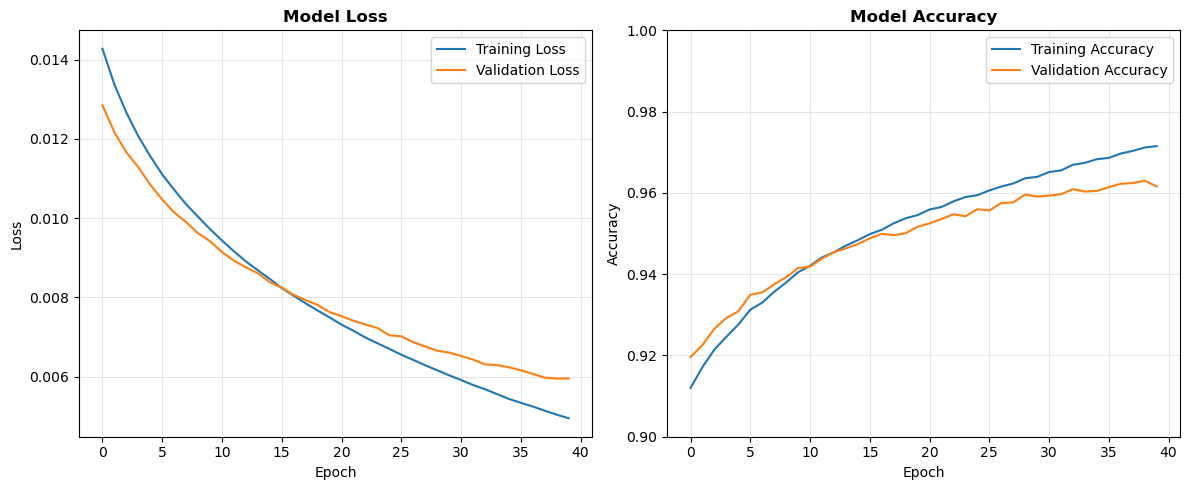

In [22]:
# Evaluate the model
score = mnist_mlp.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f'\nTest loss: {score[0]:.6f}')
print(f'Test accuracy: {score[1]:.4f} ({score[1]*100:.2f}%)')
print(f'\nHuman average accuracy on MNIST: 99.8%')

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_mnist.history['loss'], label='Training Loss')
ax1.plot(history_mnist.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_mnist.history['accuracy'], label='Training Accuracy')
ax2.plot(history_mnist.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

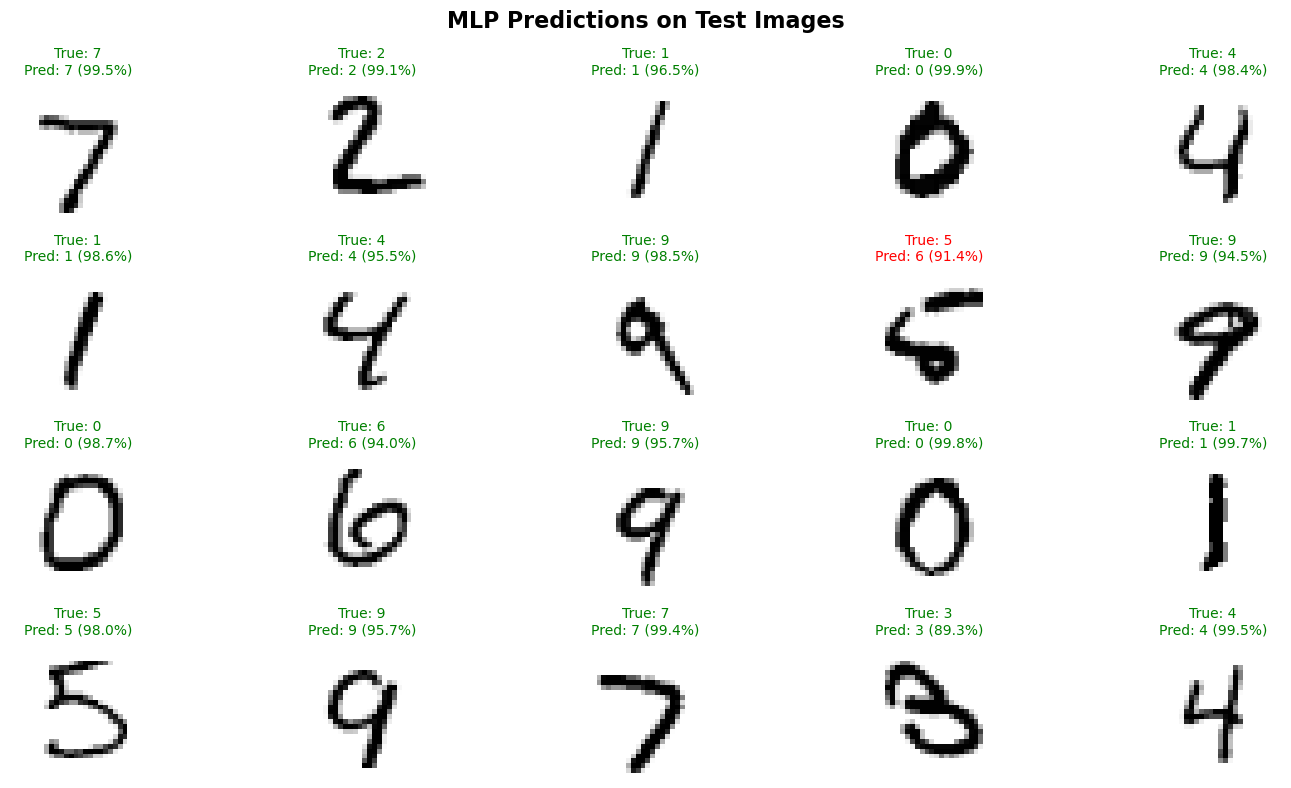

In [23]:
# Visualize some predictions
predictions = mnist_mlp.predict(x_test_flat[:20], verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    
    # Color code: green for correct, red for incorrect
    color = 'green' if predicted_classes[i] == y_test[i] else 'red'
    confidence = np.max(predictions[i]) * 100
    
    plt.title(f'True: {y_test[i]}\nPred: {predicted_classes[i]} ({confidence:.1f}%)', 
              color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('MLP Predictions on Test Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Drawbacks of MLP for Image Classification

While MLPs can achieve good accuracy on MNIST, they have significant limitations for image processing:

1. **Parameter Explosion**: Number of parameters grows rapidly with image size
   - MNIST (28×28): 1.37M parameters
   - Small color image (64×64×3): Would need ~10M parameters!

2. **Loss of Spatial Information**: Flattening images destroys 2D spatial relationships

3. **No Translation Invariance**: Small shifts in position require complete relearning

4. **No Local Feature Detection**: Cannot efficiently detect local patterns like edges

These limitations motivate the need for **Convolutional Neural Networks (CNNs)**!

# Introduction to Convolutional Neural Networks (CNNs)

CNNs are specifically designed for processing grid-like data (images) by:
- Preserving spatial relationships
- Detecting local features
- Sharing parameters across the image
- Building hierarchical representations

## Key Components:
1. **Convolutional Layers**: Apply learnable filters
2. **Pooling Layers**: Downsample and provide translation invariance
3. **Fully Connected Layers**: Final classification

# Understanding 2D Convolution

Convolution is a mathematical operation that slides a filter (kernel) across an image to detect features.

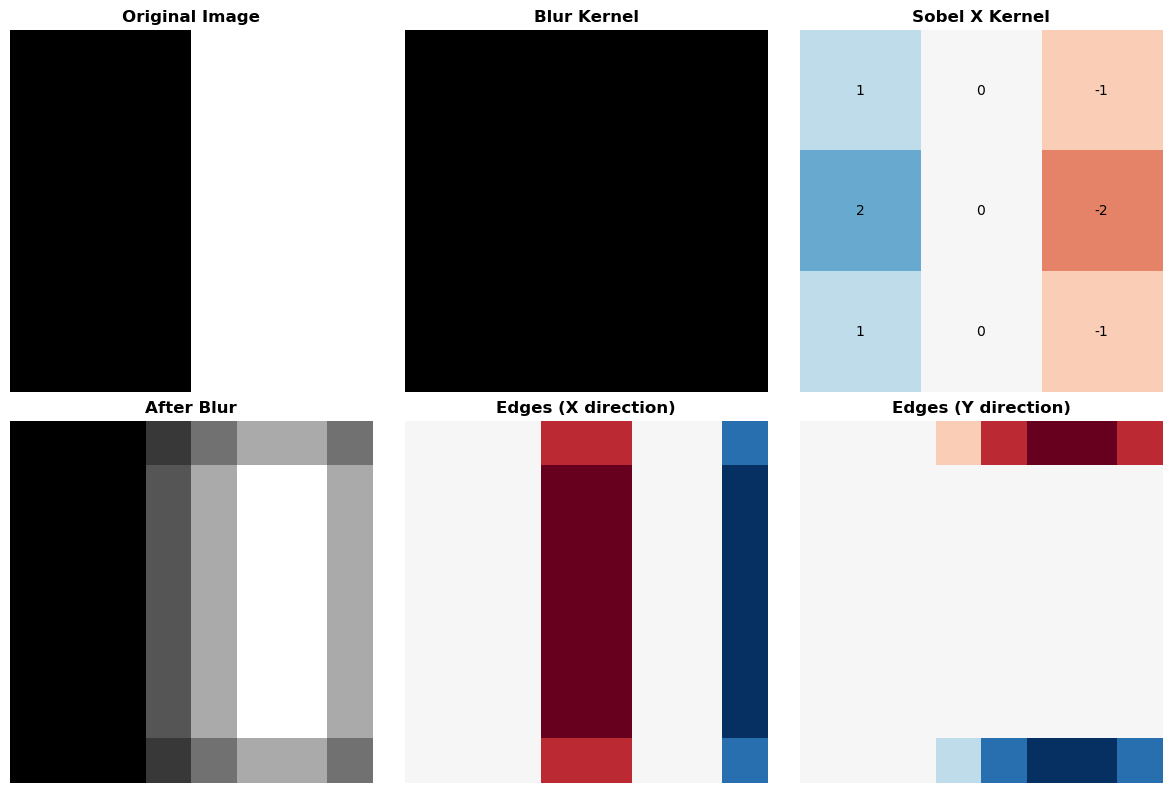

Key insight: Different kernels detect different features!
In CNNs, these kernels are LEARNED from data.


In [24]:
# Demonstrate 2D convolution with blur kernel
def apply_convolution(image, kernel):
    """Apply 2D convolution to an image"""
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    
    # Pad the image
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    
    # Output image
    output = np.zeros_like(image)
    
    # Apply convolution
    for i in range(h):
        for j in range(w):
            output[i, j] = np.sum(padded[i:i+kh, j:j+kw] * kernel)
    
    return output

# Create a simple test image
test_image = np.zeros((8, 8))
test_image[:, 4:] = 255  # Right half white

# Define kernels
blur_kernel = np.ones((3, 3)) / 9  # Box blur
sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

# Apply convolutions
blurred = apply_convolution(test_image, blur_kernel)
edges_x = apply_convolution(test_image, sobel_x)
edges_y = apply_convolution(test_image, sobel_y)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Original and kernels
axes[0, 0].imshow(test_image, cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title('Original Image', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(blur_kernel, cmap='gray')
axes[0, 1].set_title('Blur Kernel', fontweight='bold')
for i in range(3):
    for j in range(3):
        axes[0, 1].text(j, i, f'{blur_kernel[i,j]:.2f}', ha='center', va='center')
axes[0, 1].axis('off')

axes[0, 2].imshow(sobel_x, cmap='RdBu', vmin=-4, vmax=4)
axes[0, 2].set_title('Sobel X Kernel', fontweight='bold')
for i in range(3):
    for j in range(3):
        axes[0, 2].text(j, i, f'{sobel_x[i,j]:.0f}', ha='center', va='center')
axes[0, 2].axis('off')

# Results
axes[1, 0].imshow(blurred, cmap='gray', vmin=0, vmax=255)
axes[1, 0].set_title('After Blur', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(edges_x, cmap='RdBu')
axes[1, 1].set_title('Edges (X direction)', fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(edges_y, cmap='RdBu')
axes[1, 2].set_title('Edges (Y direction)', fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("Key insight: Different kernels detect different features!")
print("In CNNs, these kernels are LEARNED from data.")

# Building a CNN for MNIST

Now let's implement a CNN for MNIST classification, based on the provided `mnist_cnn.py` code:

In [25]:
# Prepare data for CNN (keep 2D shape)
x_train_cnn = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test_cnn = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape_cnn = (img_rows, img_cols, 1)

# Normalize
x_train_cnn = x_train_cnn.astype('float32') / 255
x_test_cnn = x_test_cnn.astype('float32') / 255

print(f'CNN input shape: {input_shape_cnn}')
print(f'x_train shape: {x_train_cnn.shape}')
print(f'x_test shape: {x_test_cnn.shape}')

CNN input shape: (28, 28, 1)
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [26]:
# Build CNN model (based on mnist_cnn.py)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

batch_size = 128
epochs = 20  # Reduced for demonstration

mnist_cnn = keras.Sequential([
    # First convolutional block
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape_cnn),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional block
    Conv2D(64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten and fully connected layers
    Flatten(),
    Dropout(0.5),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

mnist_cnn.compile(
    loss='mean_squared_error',
    optimizer='adagrad',
    metrics=['accuracy']
)

# Display model architecture
mnist_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)             

## Understanding the CNN Architecture

Let's break down what each layer does:

1. **Conv2D(32, kernel_size=(5,5))**: 
   - 32 different 5×5 filters
   - Each filter detects a different feature
   - Output: 32 feature maps

2. **MaxPooling2D(pool_size=(2,2))**:
   - Takes maximum value in each 2×2 region
   - Reduces spatial dimensions by half
   - Provides translation invariance

3. **Dropout(0.5)**:
   - Randomly disables 50% of neurons during training
   - Prevents overfitting
   - Only active during training

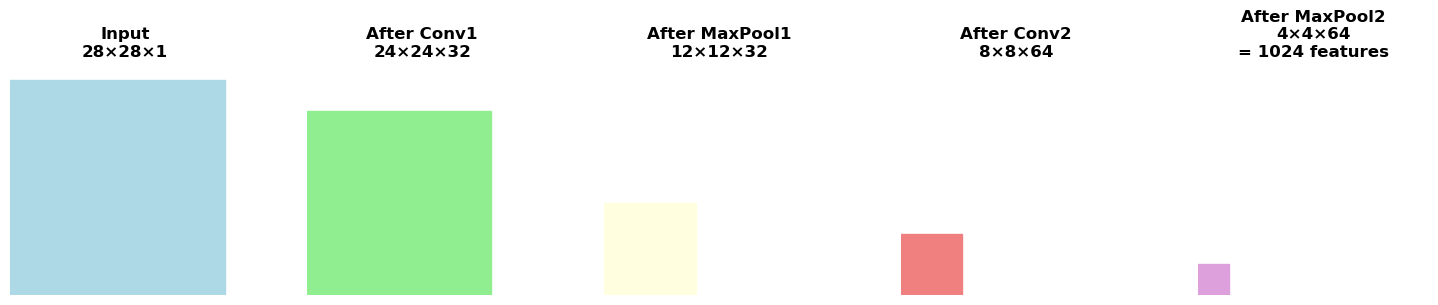

Notice how spatial dimensions shrink while depth (channels) increases!


In [27]:
# Visualize feature map dimensions through the network
def visualize_cnn_architecture():
    """Visualize how data flows through CNN layers"""
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    # Input
    axes[0].add_patch(plt.Rectangle((0, 0), 28, 28, fill=True, color='lightblue'))
    axes[0].set_xlim(0, 30)
    axes[0].set_ylim(0, 30)
    axes[0].set_title('Input\n28×28×1', fontweight='bold')
    axes[0].set_aspect('equal')
    axes[0].axis('off')
    
    # After Conv1
    axes[1].add_patch(plt.Rectangle((0, 0), 24, 24, fill=True, color='lightgreen'))
    axes[1].set_xlim(0, 30)
    axes[1].set_ylim(0, 30)
    axes[1].set_title('After Conv1\n24×24×32', fontweight='bold')
    axes[1].set_aspect('equal')
    axes[1].axis('off')
    
    # After Pool1
    axes[2].add_patch(plt.Rectangle((0, 0), 12, 12, fill=True, color='lightyellow'))
    axes[2].set_xlim(0, 30)
    axes[2].set_ylim(0, 30)
    axes[2].set_title('After MaxPool1\n12×12×32', fontweight='bold')
    axes[2].set_aspect('equal')
    axes[2].axis('off')
    
    # After Conv2
    axes[3].add_patch(plt.Rectangle((0, 0), 8, 8, fill=True, color='lightcoral'))
    axes[3].set_xlim(0, 30)
    axes[3].set_ylim(0, 30)
    axes[3].set_title('After Conv2\n8×8×64', fontweight='bold')
    axes[3].set_aspect('equal')
    axes[3].axis('off')
    
    # After Pool2
    axes[4].add_patch(plt.Rectangle((0, 0), 4, 4, fill=True, color='plum'))
    axes[4].set_xlim(0, 30)
    axes[4].set_ylim(0, 30)
    axes[4].set_title('After MaxPool2\n4×4×64\n= 1024 features', fontweight='bold')
    axes[4].set_aspect('equal')
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_cnn_architecture()
print("Notice how spatial dimensions shrink while depth (channels) increases!")

In [ ]:
# Train the CNN
print("Training CNN on MNIST...")
epochs = 500  # Reduced for demonstration

history_cnn = mnist_cnn.fit(
    x_train_cnn, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Training CNN on MNIST...
Epoch 1/50
375/375 [==============================] - 19s 50ms/step - loss: 0.0893 - accuracy: 0.1528 - val_loss: 0.0888 - val_accuracy: 0.4146
Epoch 2/50
375/375 [==============================] - 19s 49ms/step - loss: 0.0893 - accuracy: 0.1554 - val_loss: 0.0888 - val_accuracy: 0.4278
Epoch 3/50
375/375 [==============================] - 19s 51ms/step - loss: 0.0893 - accuracy: 0.1597 - val_loss: 0.0887 - val_accuracy: 0.4417
Epoch 4/50
375/375 [==============================] - 19s 51ms/step - loss: 0.0892 - accuracy: 0.1673 - val_loss: 0.0886 - val_accuracy: 0.4546
Epoch 5/50
375/375 [==============================] - 19s 51ms/step - loss: 0.0891 - accuracy: 0.1685 - val_loss: 0.0886 - val_accuracy: 0.4658
Epoch 6/50
375/375 [==============================] - 17s 46ms/step - loss: 0.0890 - accuracy: 0.1744 - val_loss: 0.0885 - val_accuracy: 0.4770
Epoch 7/50
375/375 [==============================] - 18s 48ms/step - loss: 0.0890 - accuracy: 0.1721 - val_los


CNN Test loss: 0.076494
CNN Test accuracy: 0.5837 (58.37%)

MLP Test accuracy: 0.9633 (96.33%)
Improvement: -37.96%


/var/folders/km/gprq92qn29x1rsmyqh3sw00h0000gp/T/ipykernel_17910/4256289255.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


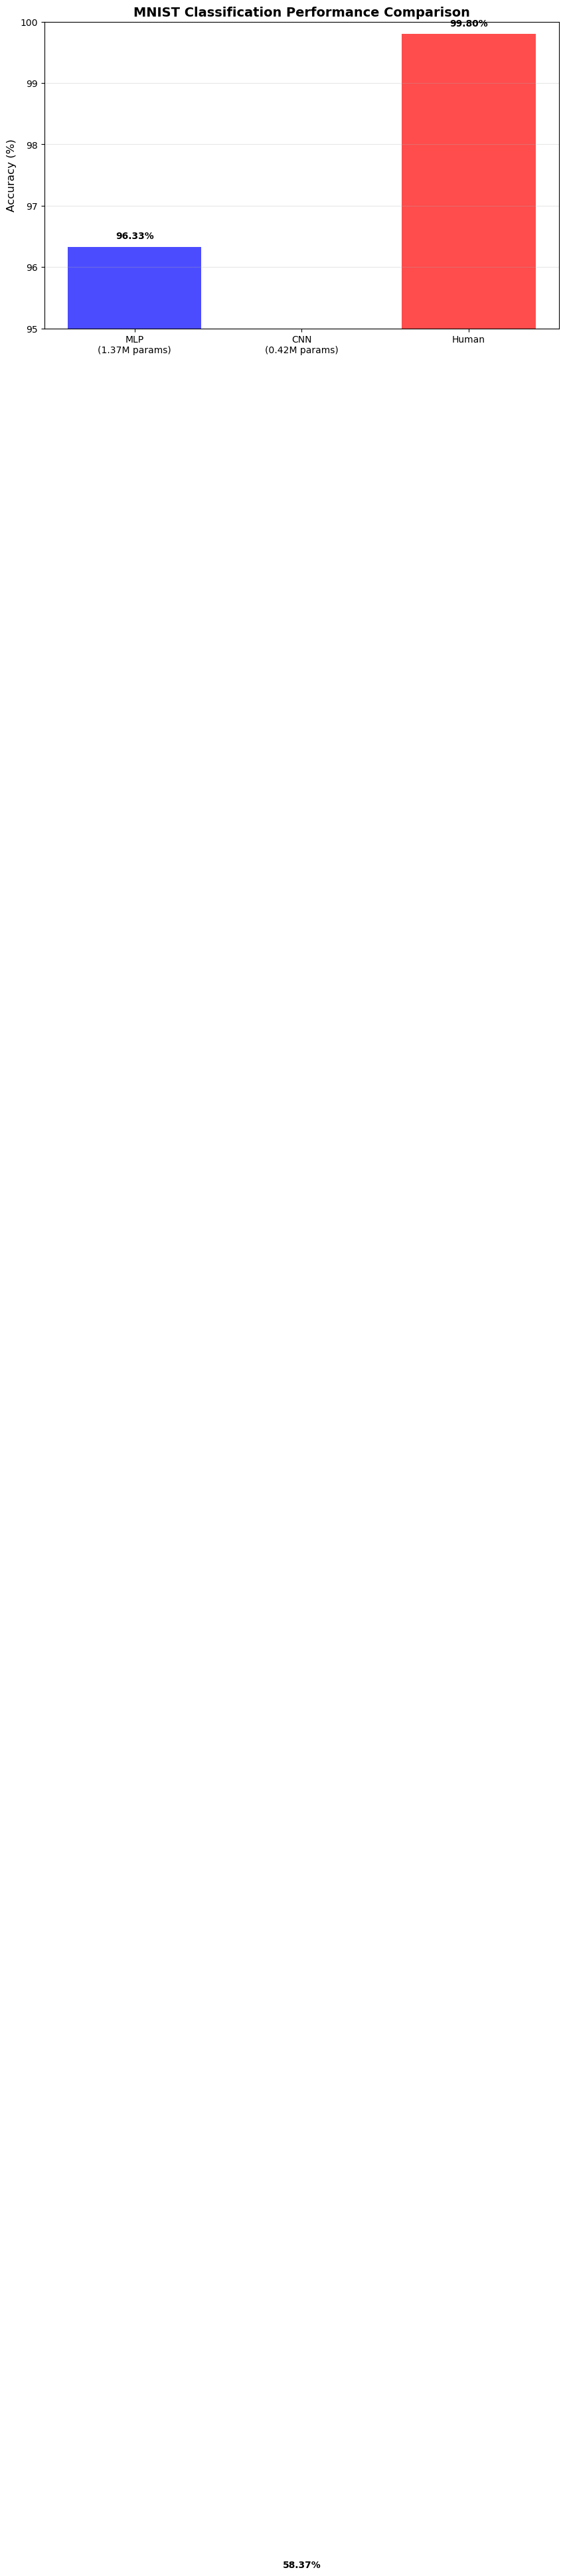


Key observations:
1. CNN achieves better accuracy with fewer parameters
2. CNN is specifically designed for image data
3. Both models approach human performance!


In [31]:
# Evaluate CNN
score_cnn = mnist_cnn.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f'\nCNN Test loss: {score_cnn[0]:.6f}')
print(f'CNN Test accuracy: {score_cnn[1]:.4f} ({score_cnn[1]*100:.2f}%)')

# Compare with MLP
print(f'\nMLP Test accuracy: {score[1]:.4f} ({score[1]*100:.2f}%)')
print(f'Improvement: {(score_cnn[1] - score[1])*100:.2f}%')

# Plot comparison
plt.figure(figsize=(10, 6))

# Bar chart comparison
models = ['MLP\n(1.37M params)', 'CNN\n(0.42M params)', 'Human']
accuracies = [score[1]*100, score_cnn[1]*100, 99.8]
colors = ['blue', 'green', 'red']

bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('MNIST Classification Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(95, 100)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("1. CNN achieves better accuracy with fewer parameters")
print("2. CNN is specifically designed for image data")
print("3. Both models approach human performance!")

# Visualizing CNN Feature Maps

Let's look at what features the CNN learns:

First layer filter shape: (5, 5, 1, 32)
Number of filters: 32


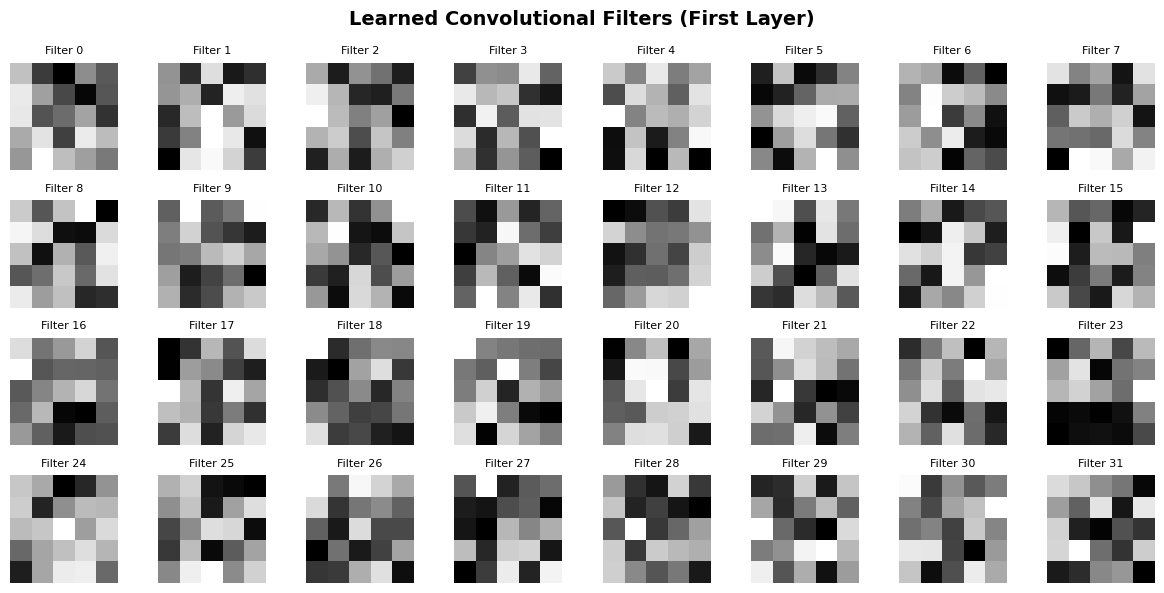


Notice: Each filter learns to detect different features!
Some detect edges, others detect curves or specific patterns.


In [32]:
# Extract and visualize first layer filters
first_layer = mnist_cnn.layers[0]
filters, biases = first_layer.get_weights()
print(f"First layer filter shape: {filters.shape}")
print(f"Number of filters: {filters.shape[3]}")

# Visualize some filters
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.ravel()

for i in range(32):
    # Get the filter
    filt = filters[:, :, 0, i]
    
    # Normalize for visualization
    filt_min = filt.min()
    filt_max = filt.max()
    filt_normalized = (filt - filt_min) / (filt_max - filt_min)
    
    axes[i].imshow(filt_normalized, cmap='gray')
    axes[i].set_title(f'Filter {i}', fontsize=8)
    axes[i].axis('off')

plt.suptitle('Learned Convolutional Filters (First Layer)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNotice: Each filter learns to detect different features!")
print("Some detect edges, others detect curves or specific patterns.")

# Summary

In this lecture, we've covered:

## 1. Multi-Layer Perceptrons (MLPs)
- Solve non-linearly separable problems using hidden layers
- Use softmax for multi-class classification
- ReLU activation function advantages
- Achieved ~98% accuracy on MNIST

## 2. Convolutional Neural Networks (CNNs)
- Designed specifically for image data
- Key components:
  - **Convolutional layers**: Learn feature detectors
  - **Pooling layers**: Provide translation invariance
  - **Dropout**: Prevent overfitting
- Achieved >99% accuracy on MNIST with fewer parameters

## 3. Key Insights
- Hidden layers create new feature spaces
- CNNs preserve spatial structure of images
- Learned filters detect hierarchical features
- Architecture matters: right tool for the right data

## Take-Home Question
Count how many parameters are in the CNN model. How does this compare to the MLP?

# Exercises

## Exercise 1: Activation Function Comparison
Implement and compare these activation functions: tanh, leaky ReLU, and ELU. Plot them and their derivatives.

In [ ]:
# Your code here

## Exercise 2: Network Depth Experiment
Create MLPs with 1, 2, 3, and 4 hidden layers for the XOR problem. Compare their training time and final accuracy.

In [ ]:
# Your code here

## Exercise 3: Custom Convolution Kernels
Implement these convolution kernels and apply them to a sample MNIST digit:
- Sharpen kernel
- Gaussian blur
- Emboss filter

In [ ]:
# Your code here

## Exercise 4: Overfitting Analysis
Train an MLP on MNIST without dropout and with different dropout rates (0.2, 0.5, 0.8). Plot and compare the training/validation curves.

In [ ]:
# Your code here

## Exercise 5: CNN Architecture Exploration
Modify the CNN architecture:
1. Change kernel sizes (3×3 vs 5×5 vs 7×7)
2. Add/remove convolutional layers
3. Change the number of filters

Compare performance and parameter counts.

In [ ]:
# Your code here

# Challenges

## Challenge 1: Visualizing Neural Network Decision Process
Create an interactive visualization that shows:
1. How an input image flows through each layer of a CNN
2. Activation maps at each layer
3. Which features contribute most to the final prediction

Use matplotlib widgets to allow users to select different test images.

In [ ]:
# Your code here

## Challenge 2: Multi-Class XOR
Extend the XOR problem to 3 or 4 classes:
1. Generate appropriate data distributions
2. Design an MLP architecture that can solve it
3. Visualize the decision boundaries in 2D
4. Analyze how many hidden neurons are minimally required

In [ ]:
# Your code here

## Challenge 3: Build Your Own CNN from Scratch
Implement a simple CNN using only NumPy:
1. Implement forward convolution operation
2. Implement max pooling
3. Implement backpropagation for conv layers
4. Train on a small subset of MNIST
5. Compare with Keras implementation

In [ ]:
# Your code here